In [1]:
import numpy as np
import minimg as mg
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from math import factorial
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def XYZ_to_RGB(XYZ):
    XYZ_to_RGB = np.array([[0.41847, -0.15866, -0.082835],
                            [-0.091169, 0.25243, 0.015708],
                            [0.000920, -0.002549, 0.17860]])
    return np.dot(XYZ_to_RGB, XYZ)

def C_sRGB(C_lin):
    if C_lin <= 0.0031308:
        return 12.92 * C_lin
    else: return 1.055 * C_lin ** (1 / 2.4) - 0.055

def RGB_to_sRGB(RGB):
    return np.array([C_sRGB(RGB[0]), C_sRGB(RGB[1]), C_sRGB(RGB[2])])

def XYZ_to_LMS(XYZ):
    XYZ_to_LMS = np.array([[0.38971, 0.68898, -0.07868],
                          [-0.22981, 1.18340, 0.04641],
                          [0.0, 0.0, 1.0]])
    return np.dot(XYZ_to_LMS, XYZ)

In [3]:
# взято из https://books.google.ru/books?id=U8jeh1uhSHgC&pg=PA167&lpg=PA167&dq=cieluv+un+vn&source=bl&ots=SV9nETcTgT&sig=ACfU3U1KpRKswHA1dO8FsjqbNdO8PxoaPg&hl=ru&sa=X&ved=2ahUKEwjI447Jo7DlAhX18KYKHSXQA5gQ6AEwAnoECAgQAQ#v=onepage&q=cieluv%20un%20vn&f=false
XYZ_WHITE_POINT_D65_X = 95.04#0.3127
XYZ_WHITE_POINT_D65_Y = 100.0#0.329
XYZ_WHITE_POINT_D65_Z = 108.89
CIELUV_D65_u_stick_n = 0.1978
CIELUV_D65_v_stick_n = 0.4683

WHITEPOINTRGB = [2754.907432227824, 2905.2600332985335, 3118.0681991097817]


In [4]:
def XYZ_to_CIELUV(c, whitePoint):
    L_star, u_star, v_star = 0, 0, 0
    X, Y, Z = c[0], c[1], c[2]
    X_n, Y_n, Z_n = whitePoint[0], whitePoint[1], whitePoint[2]
    
    u_stick_n = 4 * X_n / (X_n + 15 * Y_n + 3 * Z_n)
    v_stick_n = 9 * X_n / (X_n + 15 * Y_n + 3 * Z_n)
    
    if Y / XYZ_WHITE_POINT_D65_Y <= (6 / 29) ** 3:
        L_star = (29 / 3) ** 3 * Y / Y_n
    else:
        L_star = 116 * (Y / Y_n) ** (1 / 3) - 16
    
    u_stick = 4 * X / (X + 15 * Y + 3 * Z)
    v_stick = 9 * Y / (X + 15 * Y + 3 * Z)
    
    u_star = 13 * L_star * (u_stick - u_stick_n)
    v_star = 13 * L_star * (v_stick - v_stick_n)
    
    return np.array([L_star, u_star, v_star])

def CIELUV_DeltaE_from_XYZ(XYZ1, XYZ2, whitePoint):
    return np.linalg.norm(XYZ_to_CIELUV(XYZ1, whitePoint) - XYZ_to_CIELUV(XYZ2, whitePoint))

In [5]:
patch_spectras = ['Dark Skin.reflect', 'Light Skin.reflect', 'Blue Sky.reflect',
                 'Foilage.reflect', 'Blue Flower.reflect', 'Bluish Green.reflect',
                 'Orange.reflect', 'Purplish Blue.reflect', 'Moderate Red.reflect',
                 'Purple.reflect', 'Yellow Green.reflect', 'Orange Yellow.reflect',
                 'Blue.reflect', 'Green.reflect', 'Red.reflect',
                 'Yellow.reflect', 'Magenta.reflect', 'Cyan.reflect',
                 'White.reflect', 'Neutral-8.reflect', 'Neutral-6.5.reflect',
                 'Neutral-5.reflect', 'Neutral-3.5.reflect', 'Black.reflect']

In [6]:
x = np.linspace(380, 780, 101)

#D65 source
src = np.loadtxt("./d65.illum")
x_src = np.linspace(300, 830, 531)
src = np.interp(x, x_src, src)
D65 = np.diag(src)

#XYZ spectral sensitivities
f = open('camera.kinect1.json', 'r')
xyz_dict = json.load(f)
XYZ_R = np.array(xyz_dict['sensitivities']['red'])[:, 1]
XYZ_G = np.array(xyz_dict['sensitivities']['green'])[:, 1]
XYZ_B = np.array(xyz_dict['sensitivities']['blue'])[:, 1]
x_XYZ = np.linspace(365, 830, 94) 
sens_XYZ_R = np.interp(x, x_XYZ, XYZ_R)
sens_XYZ_G = np.interp(x, x_XYZ, XYZ_G)
sens_XYZ_B = np.interp(x, x_XYZ, XYZ_B)

#RGB camera sensitivities
cam_R, cam_G, cam_B = np.loadtxt("cam_R.spect"), np.loadtxt("cam_G.spect"), np.loadtxt("cam_B.spect")
x_RGB = np.linspace(380, 784, 101)
sens_RGB_R = np.interp(x, x_RGB, cam_R)
sens_RGB_G = np.interp(x, x_RGB, cam_G)
sens_RGB_B = np.interp(x, x_RGB, cam_B)


colorsXYZ = []
for patch in patch_spectras:
    refl = np.loadtxt("./patches/" + patch)
    X = np.dot(np.dot(sens_XYZ_R.T, D65), refl)
    Y = np.dot(np.dot(sens_XYZ_G.T, D65), refl)
    Z = np.dot(np.dot(sens_XYZ_B.T, D65), refl)
    c = np.array([X, Y, Z])
    colorsXYZ.append(c)
colorsXYZ = np.array(colorsXYZ)

colorsRGB = []
for patch in patch_spectras:
    refl = np.loadtxt("./patches/" + patch)
    R = np.dot(np.dot(sens_RGB_R.T, D65), refl)
    G = np.dot(np.dot(sens_RGB_G.T, D65), refl)
    B = np.dot(np.dot(sens_RGB_B.T, D65), refl)
    c = np.array([R, G, B])
    colorsRGB.append(c)
colorsRGB = np.array(colorsRGB)

In [9]:
X_WHITE = np.dot(sens_XYZ_R.T, src)
Y_WHITE = np.dot(sens_XYZ_G.T, src)
Z_WHITE = np.dot(sens_XYZ_B.T, src)
print("White point: ", X_WHITE, Y_WHITE, Z_WHITE)
WHITE_POINT_XYZ_D65 = [X_WHITE, Y_WHITE, Z_WHITE]

White point:  2754.907432227824 2905.2600332985335 3118.0681991097817


In [10]:
TERMS_P1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
TERMS_P2 = np.concatenate((TERMS_P1, np.array([[1 / 2, 1 / 2, 0], 
                                             [1 / 2, 0, 1 / 2], 
                                   [0, 1 / 2, 1 / 2]])))
TERMS_P3 = np.concatenate((TERMS_P2, np.array([ [1 / 3, 2 / 3, 0], 
                                             [0, 1 / 3, 2 / 3], 
                                             [1 / 3, 0, 2 / 3], 
                                             [2 / 3, 1 / 3, 0], 
                                             [0, 2 / 3, 1 / 3], 
                                             [2 / 3, 0, 1 / 3], 
                                             [1 / 3, 1 / 3, 1 / 3] ])))
TERMS_P4 = np.concatenate((TERMS_P3, np.array([ [3 / 4, 1 / 4, 0],
                                            [3 / 4, 0, 1 / 4],
                                            [1 / 4, 3 / 4, 0],
                                            [0, 3 / 4, 1 / 4],
                                            [1 / 4, 0, 3 / 4],
                                            [0, 1 / 4, 3 / 4],
                                            [2 / 4, 1 / 4, 1 / 4],
                                            [1 / 4, 2 / 4, 1 / 4],
                                            [1 / 4, 1 / 4, 2 / 4] ])))
POLYTERMS = np.array([TERMS_P1, TERMS_P2, TERMS_P3, TERMS_P4])

In [14]:
#! Input:
#!     X - array 3xN
#!     power - power of polynoms
#! Output:
#!     PxN array, where P - amount of root-polynomial terms
def get_rp_features(X, power):
    terms = POLYTERMS[0]
    if power == 2: terms = POLYTERMS[1]
    if power == 3: terms = POLYTERMS[2]
    if power == 4: terms = POLYTERMS[3]
    features = []
    for term in terms:
        #print("term: ", term)
        a = np.power(X.T, term)
        #print("a: ", a)
        b = np.prod(a, axis = 1)
        #print("b: ", b)
        features.append(b)
    return np.array(features)

def q_rp_features(power):
    if power == 2: return 6
    if power == 3: return 13
    if power == 4: return 22
    else: return 3

In [15]:
power = 1

In [16]:
R = colorsRGB.T
R = get_rp_features(R, power)
Q = colorsXYZ.T
print("R shape: ", R.shape)
print("Q shape: ", Q.shape)

y_r = Q[0]
y_g = Q[1]
y_b = Q[2]
X = R.T
print(X.shape)

R shape:  (3, 24)
Q shape:  (3, 24)
(24, 3)


In [17]:
LOO = LeaveOneOut()
err = 0
for train_index, test_index in LOO.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_r_train, y_r_test = y_r[train_index], y_r[test_index]
    y_g_train, y_g_test = y_g[train_index], y_g[test_index]
    y_b_train, y_b_test = y_b[train_index], y_b[test_index]
    clsfR = LinearRegression()
    clsfG = LinearRegression()
    clsfB = LinearRegression()
    clsfR.fit(X_train, y_r_train)
    clsfG.fit(X_train, y_g_train)
    clsfB.fit(X_train, y_b_train)
    
    prR = clsfR.predict(X_test)
    prG = clsfG.predict(X_test)
    prB = clsfB.predict(X_test)
    
    A = np.zeros((3, q_rp_features(power)))
    A[0] = clsfR.coef_
    A[1] = clsfG.coef_
    A[2] = clsfB.coef_
    
    #print(A)
    
    pred = np.array([prR[0], prG[0], prB[0]])
    gt = np.array([y_r_test[0], y_g_test[0], y_b_test[0],])
    print("=========")
    print("gt:", gt)
    print("pred: ", pred)
    print("A*raw:", np.dot(A, X_test[0]))
    #ang = 180 * np.arccos(np.round(np.dot(pred, gt) / np.linalg.norm(pred) / np.linalg.norm(gt), 8)) / np.pi
    DeltaE = CIELUV_DeltaE_from_XYZ(pred, gt, WHITE_POINT_XYZ_D65)
    print(DeltaE)
    err += DeltaE
print("!mean: ", err / 24)

gt: [318.9394091  289.27117144 205.44411305]
pred:  [324.00806775 287.5433957  205.07261581]
A*raw: [322.73504656 294.12028048 215.5657443 ]
2.380436194282813
gt: [1001.45874109  945.74111229  709.30746042]
pred:  [1014.91938333  956.15005214  713.68945643]
A*raw: [1013.95559181  962.40554533  724.08260545]
0.8204729746290625
gt: [489.78028242 536.60625771 939.30494455]
pred:  [487.60000034 531.24742101 950.00749811]
A*raw: [486.94894442 537.94501609 959.88018231]
1.4950985926287856
gt: [283.36297245 344.62853133 193.60818096]
pred:  [279.5607398  344.83160499 188.52793275]
A*raw: [279.21538224 351.21432543 199.55148144]
1.4081556847233576
gt: [ 676.89070139  669.4389975  1200.66611555]
pred:  [ 683.17680273  674.39118089 1209.70213105]
A*raw: [ 682.2741643   680.69203725 1219.9676369 ]
0.2946193352909636
gt: [ 872.95120847 1180.29327278 1194.0041255 ]
pred:  [ 885.92621649 1183.50580612 1204.16243649]
A*raw: [ 884.77814934 1189.81758077 1214.32265077]
1.601543644311686
gt: [999.276348

In [18]:
a = XYZ_to_CIELUV(np.array([274.07249923, 281.11144134, 308.43766985]), WHITE_POINT_XYZ_D65)
a

array([37.25444054,  2.19548136, 10.60467849])

In [19]:
b = XYZ_to_CIELUV(np.array([272.32453864, 286.37371819, 307.91985194]), WHITE_POINT_XYZ_D65)
b

array([37.58468789,  0.23079971, 11.7690208 ])

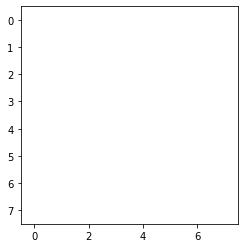

In [20]:
a = np.zeros((8, 8, 3))
a[:, :] = WHITE_POINT_XYZ_D65
plt.imshow(a / np.array(a))